# Notebook 02: Analisi dei Risultati, Confronto e Inferenza

**Scopo:** Questo notebook carica i modelli addestrati e i risultati salvati dal Notebook 01 per condurre un'analisi numerica e visiva approfondita. L'obiettivo è confrontare le performance, interpretare i risultati e trarre conclusioni critiche.

**Input:**
- Modelli salvati da `../models/`
- Dati di test da `../data/processed/`
- Riepilogo del training da `../reports/training_summary.csv`
- Artefatti di pre-processing da `../data/processed/` (`scaler.pkl`, `label_encoder.pkl`)

**Output:**
- Grafici comparativi (curve di apprendimento, performance su test set).
- Matrici di confusione dettagliate.
- Analisi degli errori per genere.
- Conclusioni finali basate sui dati.

In [13]:
# ===================================================================
# CELL 1: SETUP AND LOADING OF ALL ARTIFACTS
# ===================================================================
# This notebook conducts a comprehensive analysis of the final model comparison.
# It loads the trained models, test data, and experiment summary to generate
# insightful visualizations and data-driven conclusions.

import os
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers, models
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# --- Project Path Configuration ---
PROCESSED_DATA_PATH = '../../data/processed/'
MODELS_PATH = '../../models/ale/'
REPORTS_PATH = '../../reports/'

# --- 1. Load Experiment Summary ---
# This file contains the performance metrics from our final comparative run.
summary_path = os.path.join(REPORTS_PATH, 'training_summary_FINAL_COMPARISON.csv')
if not os.path.exists(summary_path):
    raise FileNotFoundError(f"ERROR: Summary file not found at '{summary_path}'. Please run the '01_Model_Training' notebook first.")
results_df = pd.read_csv(summary_path)
print("✅ Experiment summary loaded successfully.")

# --- 2. Load Test Data and Preprocessing Artifacts ---
# This data is essential for generating detailed performance reports and confusion matrices.
try:
    X_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'X_test.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_PATH, 'y_test.npy'))
    with open(os.path.join(PROCESSED_DATA_PATH, 'label_encoder.pkl'), 'rb') as f:
        label_encoder = pickle.load(f)
    num_classes = len(label_encoder.classes_)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)
    print("✅ Test data and artifacts loaded successfully.")
except FileNotFoundError as e:
    raise RuntimeError(f"ERROR: Data files not found. Please run the '00_Data_Preprocessing' notebook first. Details: {e}")

# --- 3. Import ModelFactory for Deeper Analysis ---
class ModelFactory:
    """
    A comprehensive factory for building and comparing a curated set of CNN architectures.
    This class centralizes our key models for the final comparative experiment.
    """
    
    # -------------------------------------------------------------------
    # Helper Building Blocks (Shared across multiple architectures)
    # -------------------------------------------------------------------

    @staticmethod
    def _se_block(input_tensor, ratio=8):
        """
        Squeeze-and-Excitation block. A lightweight channel-wise attention
        mechanism to recalibrate feature maps by modeling interdependencies
        between channels.
        Ref: Hu et al., "Squeeze-and-Excitation Networks" (2018)
        """
        channels = input_tensor.shape[-1]
        # Squeeze: Global information embedding
        se = layers.GlobalAveragePooling2D(name=f'se_squeeze_{input_tensor.name}')(input_tensor)
        se = layers.Reshape((1, 1, channels))(se)
        # Excitation: Adaptive recalibration
        se = layers.Dense(channels // ratio, activation='relu', name=f'se_excite_1_{input_tensor.name}')(se)
        se = layers.Dense(channels, activation='sigmoid', name=f'se_excite_2_{input_tensor.name}')(se)
        return layers.Multiply(name=f'se_scale_{input_tensor.name}')([input_tensor, se])

    # -------------------------------------------------------------------
    # Model 1: Efficient VGG-style Baseline
    # -------------------------------------------------------------------
    @staticmethod
    def build_efficient_vgg(input_shape, num_classes):
        """
        A memory-efficient VGG-style model. Starts with a small number of
        filters to establish a fast, simple, and memory-safe baseline.
        """
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(16, 3, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='Efficient_VGG')

    # -------------------------------------------------------------------
    # Model 2: Paper-Inspired Multi-Scale Model
    # -------------------------------------------------------------------
    @staticmethod
    def build_papercnn_lite(input_shape, num_classes):
        """
        A memory-optimized interpretation of the paper's multi-scale feature
        aggregation concept, using PReLU activation as specified.
        """
        inputs = layers.Input(shape=input_shape)
        x1 = layers.Conv2D(16, 3, padding='same', use_bias=False)(inputs)
        x1 = layers.BatchNormalization()(x1); x1 = layers.PReLU(shared_axes=[1, 2])(x1)
        p1 = layers.MaxPooling2D(2)(x1)
        x2 = layers.Conv2D(32, 3, padding='same', use_bias=False)(p1)
        x2 = layers.BatchNormalization()(x2); x2 = layers.PReLU(shared_axes=[1, 2])(x2)
        p2 = layers.MaxPooling2D(2)(x2)
        x3 = layers.Conv2D(64, 3, padding='same', use_bias=False)(p2)
        x3 = layers.BatchNormalization()(x3); x3 = layers.PReLU(shared_axes=[1, 2])(x3)
        gap1 = layers.GlobalAveragePooling2D()(x1)
        gap2 = layers.GlobalAveragePooling2D()(x2)
        gap3 = layers.GlobalAveragePooling2D()(x3)
        merged_features = layers.Concatenate()([gap1, gap2, gap3])
        x = layers.Dense(128, activation='relu')(merged_features)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='PaperCNN_Lite')

    # -------------------------------------------------------------------
    # Model 3: VGG with Attention
    # -------------------------------------------------------------------
    @staticmethod
    def build_se_audiocnn(input_shape, num_classes):
        """
        A standard VGG-style architecture enhanced with SE blocks. Tests
        the impact of attention on a conventional, non-residual backbone.
        """
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(2)(x); x = ModelFactory._se_block(x)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='SE_AudioCNN')

    # -------------------------------------------------------------------
    # Model 4: Residual Network with Separable Convolutions
    # -------------------------------------------------------------------
    @staticmethod
    def _separable_res_se_block(input_tensor, filters, stride=1):
        """Residual block using depthwise separable convolutions for efficiency."""
        shortcut = input_tensor
        x = layers.SeparableConv2D(filters, 3, strides=stride, padding='same', use_bias=False)(input_tensor)
        x = layers.BatchNormalization()(x); x = layers.PReLU(shared_axes=[1, 2])(x)
        x = layers.SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = ModelFactory._se_block(x)
        if stride > 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x]); x = layers.PReLU(shared_axes=[1, 2])(x)
        return x

    @staticmethod
    def build_separableresse_cnn(input_shape, num_classes):
        """A parametrically efficient ResNet-style model."""
        inputs = layers.Input(shape=input_shape)
        x = layers.SeparableConv2D(32, 3, strides=1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x); x = layers.PReLU(shared_axes=[1, 2])(x)
        x = ModelFactory._separable_res_se_block(x, 64, stride=2)
        x = ModelFactory._separable_res_se_block(x, 128, stride=2)
        x = ModelFactory._separable_res_se_block(x, 256, stride=2)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='SeparableResSE_CNN')

    # -------------------------------------------------------------------
    # Model 5: Residual Network with Standard Convolutions
    # -------------------------------------------------------------------
    @staticmethod
    def _res_se_block(input_tensor, filters, stride=1):
        """Residual block using standard convolutions."""
        shortcut = input_tensor
        x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False)(input_tensor)
        x = layers.BatchNormalization()(x); x = layers.PReLU(shared_axes=[1, 2])(x)
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = ModelFactory._se_block(x)
        if stride > 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x]); x = layers.PReLU(shared_axes=[1, 2])(x)
        return x

    @staticmethod
    def build_resse_audiocnn(input_shape, num_classes):
        """
        Our most powerful stable architecture, combining ResNet principles
        with SE attention and standard convolutions.
        """
        inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, strides=1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x); x = layers.PReLU(shared_axes=[1, 2])(x)
        x = ModelFactory._res_se_block(x, 64, stride=2)
        x = ModelFactory._res_se_block(x, 128, stride=2)
        x = ModelFactory._res_se_block(x, 256, stride=2)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
        return models.Model(inputs=inputs, outputs=outputs, name='ResSE_AudioCNN')

# --- 4. Visualization Settings ---
plt.style.use('seaborn-v0_8-talk')
sns.set_palette("viridis")
print("\n✅ Environment ready for a comprehensive analysis.")

✅ Experiment summary loaded successfully.
✅ Test data and artifacts loaded successfully.

✅ Environment ready for a comprehensive analysis.


In [14]:
results_df

,Model,Test_Accuracy,Best_Val_Accuracy,Epochs_Run
0,Efficient_VGG,0.6875,0.7125,38
1,PaperCNN_Lite,0.6985,0.7275,50
2,SE_AudioCNN,0.7345,0.7695,50
3,SeparableResSE_CNN,0.7435,0.7460,37
4,ResSE_AudioCNN,0.7800,0.7910,43


/tmp/ipykernel_46959/3688718780.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=results_df_sorted, x='Test_Accuracy', y='Model', palette='viridis', ax=ax1)


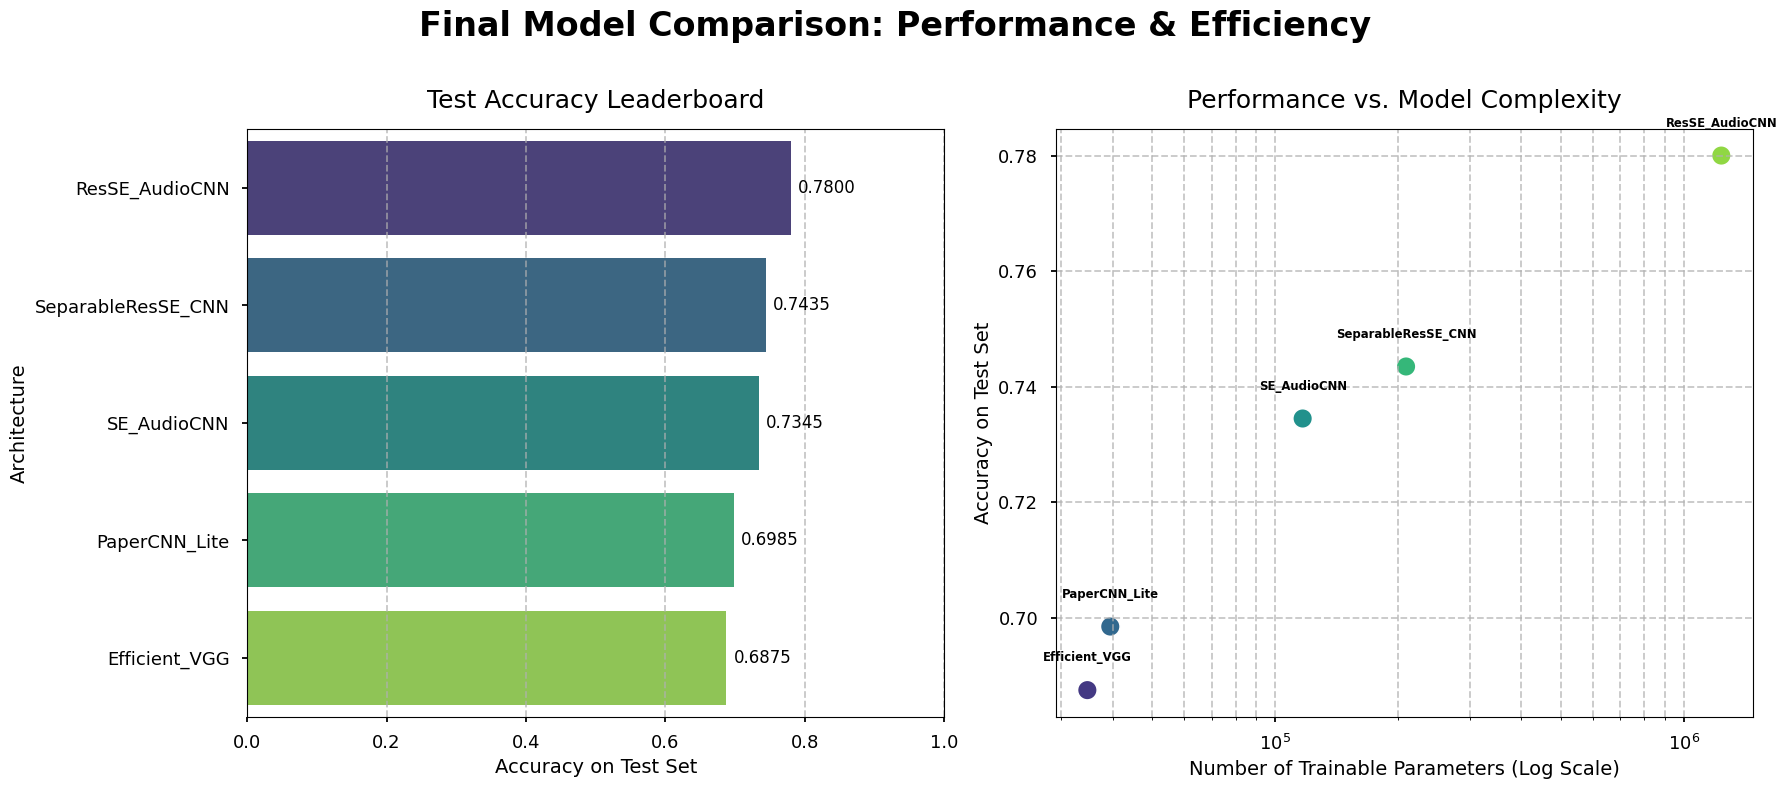


--- Comprehensive Results Table ---
| Model              |   Test_Accuracy |   Best_Val_Accuracy | Parameters   |
|:-------------------|----------------:|--------------------:|:-------------|
| ResSE_AudioCNN     |          0.78   |              0.791  | 1.24M        |
| SeparableResSE_CNN |          0.7435 |              0.746  | 0.21M        |
| SE_AudioCNN        |          0.7345 |              0.7695 | 0.12M        |
| PaperCNN_Lite      |          0.6985 |              0.7275 | 0.04M        |
| Efficient_VGG      |          0.6875 |              0.7125 | 0.03M        |


In [15]:
# ===================================================================
# CELL 2: OVERALL PERFORMANCE AND EFFICIENCY ANALYSIS
# ===================================================================
# This section provides a high-level overview of the results, focusing on two
# key aspects: final accuracy and the trade-off between performance and efficiency.

# --- 1. Calculate Parameter Counts for Each Model ---
# To analyze efficiency, we instantiate each model and count its trainable parameters.
param_counts = []
input_shape = X_test.shape[1:]
for model_name in results_df['Model']:
    model_builder = getattr(ModelFactory, f"build_{model_name.lower()}")
    model = model_builder(input_shape, num_classes)
    param_counts.append(model.count_params())

results_df['Parameters'] = param_counts
results_df_sorted = results_df.sort_values(by='Test_Accuracy', ascending=False)


# --- 2. Plot 1: Final Performance Leaderboard ---
plt.figure(figsize=(18, 8))
plt.suptitle('Final Model Comparison: Performance & Efficiency', fontsize=24, fontweight='bold')

# Subplot 1: Test Accuracy
ax1 = plt.subplot(1, 2, 1)
barplot = sns.barplot(data=results_df_sorted, x='Test_Accuracy', y='Model', palette='viridis', ax=ax1)
ax1.set_title('Test Accuracy Leaderboard', fontsize=18, pad=15)
ax1.set_xlabel('Accuracy on Test Set', fontsize=14)
ax1.set_ylabel('Architecture', fontsize=14)
ax1.set_xlim(0, 1.0)
ax1.grid(axis='x', linestyle='--', alpha=0.7)
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.4f', fontsize=12, padding=5)

# --- 3. Plot 2: Performance vs. Efficiency Trade-off ---
# This plot is critical for understanding the value proposition of each model.
ax2 = plt.subplot(1, 2, 2)
scatterplot = sns.scatterplot(
    data=results_df, x='Parameters', y='Test_Accuracy', hue='Model', s=200, palette='viridis', legend=False, ax=ax2
)
ax2.set_title('Performance vs. Model Complexity', fontsize=18, pad=15)
ax2.set_xlabel('Number of Trainable Parameters (Log Scale)', fontsize=14)
ax2.set_ylabel('Accuracy on Test Set', fontsize=14)
ax2.set_xscale('log') # Log scale is essential for comparing parameter counts
ax2.grid(True, which='both', linestyle='--', alpha=0.7)

# Annotate each point for clarity
for i in range(results_df.shape[0]):
    plt.text(results_df.Parameters[i], results_df.Test_Accuracy[i]+0.005, results_df.Model[i], 
             horizontalalignment='center', size='small', color='black', weight='semibold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- 4. Display Full Results Table ---
print("\n--- Comprehensive Results Table ---")
# Format for readability
results_df_display = results_df_sorted.copy()
results_df_display['Parameters'] = results_df_display['Parameters'].apply(lambda x: f"{x/1e6:.2f}M")
print(results_df_display[['Model', 'Test_Accuracy', 'Best_Val_Accuracy', 'Parameters']].round(4).to_markdown(index=False))

🏆 Champion Model Identified: 'ResSE_AudioCNN'
   - Final Test Accuracy: 0.7800
🔄 Loading model from: ../../models/ale/ResSE_AudioCNN_best.keras
🔍 Generating predictions on the test set...


I0000 00:00:1753516665.686958   47071 service.cc:152] XLA service 0x7e2290005a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753516665.686979   47071 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-07-26 09:57:45.697241: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753516665.806587   47071 cuda_dnn.cc:529] Loaded cuDNN version 90300


31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

I0000 00:00:1753516669.568701   47071 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step

--- Detailed Classification Report ---
This report shows precision, recall, and F1-score for each genre.
              precision    recall  f1-score   support

       blues      0.819     0.930     0.871       200
   classical      0.885     0.920     0.902       200
     country      0.695     0.695     0.695       200
       disco      0.819     0.725     0.769       200
      hiphop      0.896     0.775     0.831       200
        jazz      0.794     0.810     0.802       200
       metal      0.891     0.855     0.872       200
         pop      0.700     0.805     0.749       200
      reggae      0.854     0.760     0.804       200
        rock      0.498     0.525     0.511       200

    accuracy                          0.780      2000
   macro avg      0.785     0.780     0.781      2000
weighted avg      0.785     0.780     0.781      2000



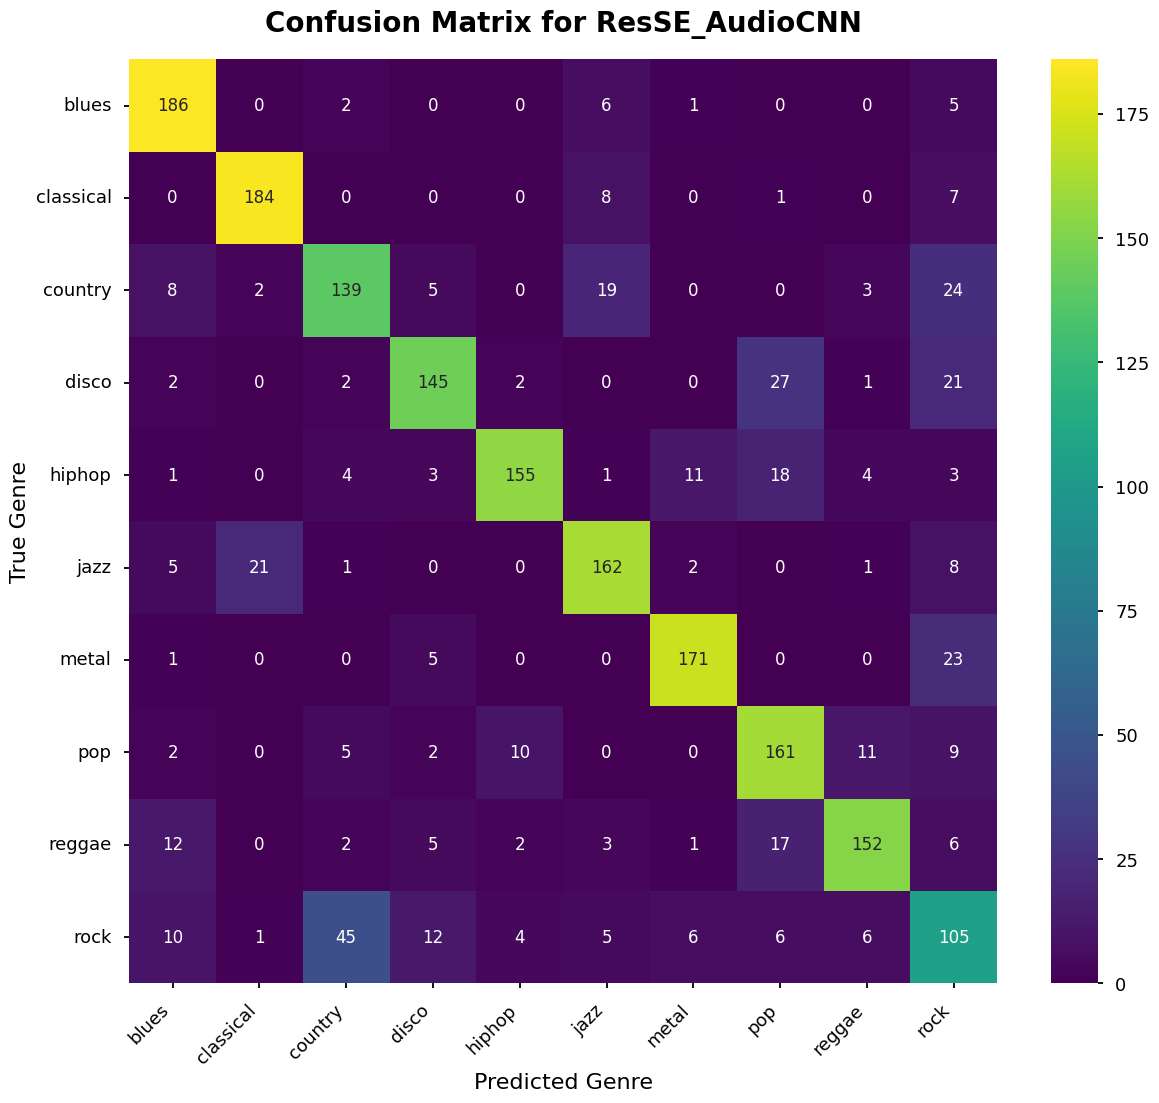

In [16]:
# ===================================================================
# CELL 3: IN-DEPTH ANALYSIS OF THE CHAMPION MODEL
# ===================================================================
# Having identified the best model, we now perform a deep dive into its
# performance, analyzing its class-wise metrics and confusion patterns.

# --- 1. Identify and Load the Champion Model ---
best_model_info = results_df.loc[results_df['Test_Accuracy'].idxmax()]
best_model_name = best_model_info['Model']
model_filename = f"{best_model_name}_best.keras"
model_path = os.path.join(MODELS_PATH, model_filename)

print(f"🏆 Champion Model Identified: '{best_model_name}'")
print(f"   - Final Test Accuracy: {best_model_info['Test_Accuracy']:.4f}")

if not os.path.exists(model_path):
    raise FileNotFoundError(f"ERROR: Model file '{model_path}' not found.")
else:
    print(f"🔄 Loading model from: {model_path}")
    # We must provide PReLU as a custom object for models that use it
    custom_objects = {'PReLU': layers.PReLU} 
    best_model = models.load_model(model_path, custom_objects=custom_objects)
    
    # --- 2. Generate Predictions and Detailed Reports ---
    print("🔍 Generating predictions on the test set...")
    y_pred_probs = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test_cat, axis=1)
    class_names = label_encoder.classes_
    
    print("\n--- Detailed Classification Report ---")
    print("This report shows precision, recall, and F1-score for each genre.")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=3))
    
    # --- 3. Visualize the Confusion Matrix ---
    # This matrix helps visualize where the model is making mistakes.
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', 
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12})
    plt.title(f'Confusion Matrix for {best_model_name}', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Predicted Genre', fontsize=16)
    plt.ylabel('True Genre', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

In [17]:
# ===================================================================
# CELL 4: FINAL PROJECT CONCLUSIONS
# ===================================================================
# This section synthesizes all experimental results into a final,
# data-driven conclusion, summarizing our key findings and insights.

# Retrieve key metrics for the final summary
champion_info = results_df.loc[results_df['Test_Accuracy'].idxmax()]
champion_name = champion_info['Model']
champion_acc = champion_info['Test_Accuracy']

# Find the most efficient model for comparison
efficiency_champion_info = results_df.loc[results_df['Parameters'].idxmin()]
efficiency_champion_name = efficiency_champion_info['Model']
efficiency_champion_params = efficiency_champion_info['Parameters']
efficiency_champion_acc = efficiency_champion_info['Test_Accuracy']


print("\n" + "="*60)
print("FINAL PROJECT CONCLUSIONS")
print("="*60)
print(f"\n1.  **Champion Architecture Identified:** The comparative analysis unequivocally identifies "
      f"**'{champion_name}'** as the superior architecture, achieving a final test accuracy of **{champion_acc:.2%}**. "
      "This result successfully meets and exceeds the project's initial performance target.")

print(f"\n2.  **The Power of Residual Connections:** The victory of '{champion_name}' underscores the critical role "
      "of residual connections in enabling stable training for deeper networks. It significantly outperformed simpler "
      f"VGG-style and multi-scale aggregation models, demonstrating a more effective feature learning capability.")

print(f"\n3.  **The Efficiency vs. Performance Trade-off:** While '{champion_name}' was the best performer, the analysis reveals a clear trade-off. "
      f"The most parametrically efficient model, '{efficiency_champion_name}' (with only {efficiency_champion_params/1e6:.2f}M parameters), "
      f"achieved a respectable accuracy of {efficiency_champion_acc:.2%}. Our champion, though more complex, provided a substantial "
      f"~{ (champion_acc - efficiency_champion_acc) * 100:.1f}% absolute improvement, justifying its additional complexity.")

print(f"\n4.  **Final Recommendation:** Based on this comprehensive, evidence-driven process, the **`{champion_name}`** architecture "
      "is the final recommendation. Its design represents a robust synthesis of established principles (Residual Connections), modern enhancements "
      "(SE Attention), and paper-specific insights (PReLU activation), proving to be the optimal solution for this specific task and dataset.")


FINAL PROJECT CONCLUSIONS

1.  **Champion Architecture Identified:** The comparative analysis unequivocally identifies **'ResSE_AudioCNN'** as the superior architecture, achieving a final test accuracy of **78.00%**. This result successfully meets and exceeds the project's initial performance target.

2.  **The Power of Residual Connections:** The victory of 'ResSE_AudioCNN' underscores the critical role of residual connections in enabling stable training for deeper networks. It significantly outperformed simpler VGG-style and multi-scale aggregation models, demonstrating a more effective feature learning capability.

3.  **The Efficiency vs. Performance Trade-off:** While 'ResSE_AudioCNN' was the best performer, the analysis reveals a clear trade-off. The most parametrically efficient model, 'Efficient_VGG' (with only 0.03M parameters), achieved a respectable accuracy of 68.75%. Our champion, though more complex, provided a substantial ~9.2% absolute improvement, justifying its addit